# pyiron_workflow

https://github.com/BAMresearch/NFDI4IngScientificWorkflowRequirements

## Define workflow with pyiron_workflow

In [1]:
import os

In [2]:
from workflow import (
    generate_mesh as _generate_mesh, 
    convert_to_xdmf as _convert_to_xdmf,
    poisson as _poisson,
    plot_over_line as _plot_over_line,
    substitute_macros as _substitute_macros,
    compile_paper as _compile_paper,
)

In [3]:
from pyiron_workflow import Workflow, to_function_node
from pyironflow import PyironFlow

from python_workflow_definition.pyiron_workflow import write_workflow_json

In [4]:
generate_mesh = to_function_node("generate_mesh", _generate_mesh, "generate_mesh")
convert_to_xdmf = to_function_node("convert_to_xdmf", _convert_to_xdmf, "convert_to_xdmf")
poisson = to_function_node("poisson", _poisson, "poisson")
plot_over_line = to_function_node("plot_over_line", _plot_over_line, "plot_over_line")
substitute_macros = to_function_node("substitute_macros", _substitute_macros, "substitute_macros")
compile_paper = to_function_node("compile_paper", _compile_paper, "compile_paper")

In [5]:
wf = Workflow("my_workflow")

In [6]:
wf.domain_size = 2.0

In [7]:
wf.source_directory = os.path.abspath(os.path.join(os.curdir, "source"))

In [8]:
wf.gmsh_output_file = generate_mesh(
    domain_size=wf.domain_size,
    source_directory=wf.source_directory,
)

In [9]:
wf.meshio_output_dict = convert_to_xdmf(
    gmsh_output_file=wf.gmsh_output_file,
)

In [10]:
wf.poisson_dict = poisson(
    meshio_output_xdmf=wf.meshio_output_dict["xdmf_file"], 
    meshio_output_h5=wf.meshio_output_dict["h5_file"],
    source_directory=wf.source_directory,
)

In [11]:
wf.pvbatch_output_file = plot_over_line(
    poisson_output_pvd_file=wf.poisson_dict["pvd_file"], 
    poisson_output_vtu_file=wf.poisson_dict["vtu_file"],
    source_directory=wf.source_directory,
)

In [12]:
wf.macros_tex_file = substitute_macros( 
    pvbatch_output_file=wf.pvbatch_output_file, 
    ndofs=wf.poisson_dict["numdofs"], 
    domain_size=wf.domain_size,
    source_directory=wf.source_directory,
)

In [13]:
wf.paper_output = compile_paper(
    macros_tex=wf.macros_tex_file, 
    plot_file=wf.pvbatch_output_file,
    source_directory=wf.source_directory,
)

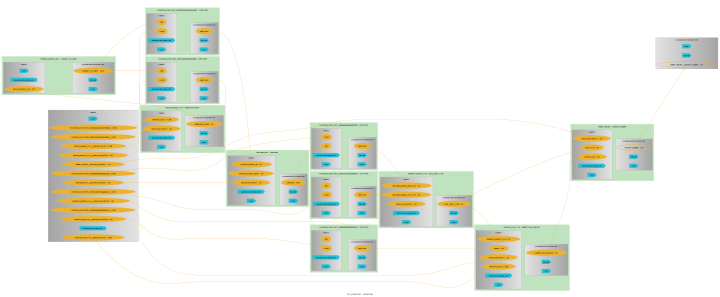

In [14]:
wf.draw(size=(10,10))

In [15]:
pf = PyironFlow([wf])
pf.gui

In [16]:
workflow_json_filename = "pyiron_workflow_nfdi.json"

In [17]:
write_workflow_json(graph_as_dict=wf.graph_as_dict, file_name=workflow_json_filename)

## Load Workflow with executorlib

In [18]:
from executorlib import SingleNodeExecutor

In [19]:
from python_workflow_definition.executorlib import load_workflow_json

In [20]:
with SingleNodeExecutor(max_workers=1) as exe:
    result = load_workflow_json(file_name=workflow_json_filename, exe=exe).result()

/home/jan/miniforge3/envs/processing/lib/python3.9/site-packages/ufl/__init__.py:250: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [21]:
result

'/home/jan/notebooks/2026/2026-02-04-pyiron-core-pwd/postprocessing/paper.pdf'

## Load Workflow with pyiron_base

In [22]:
from python_workflow_definition.pyiron_base import load_workflow_json

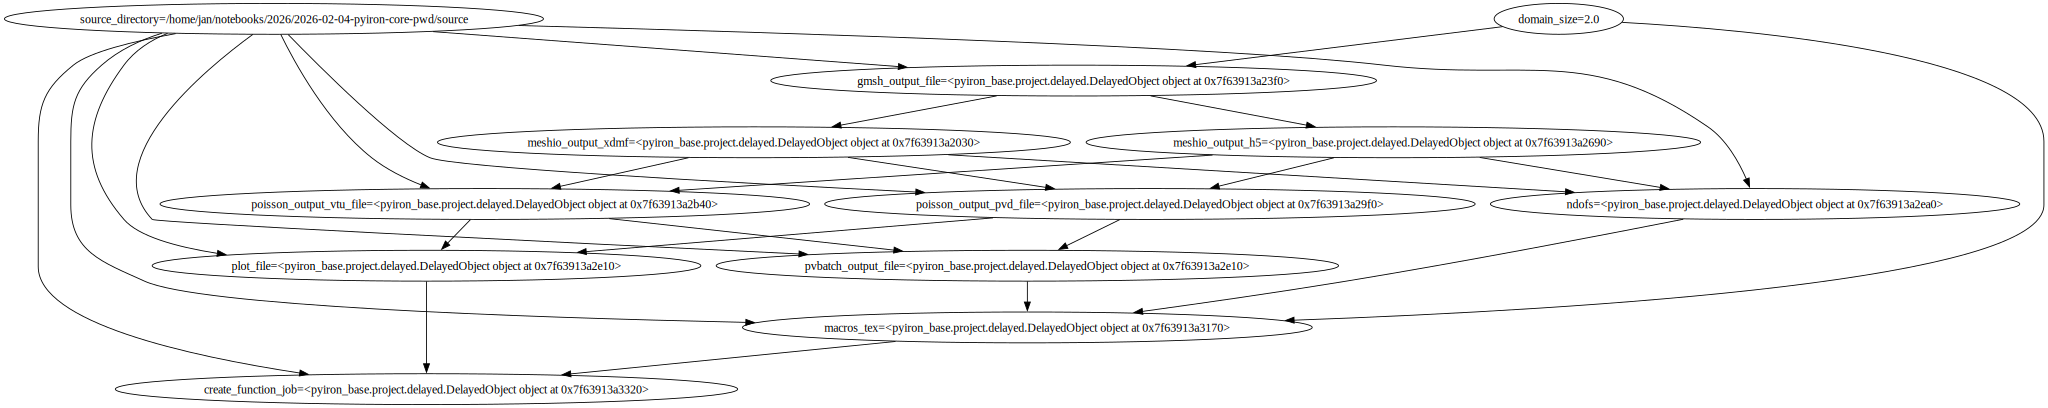

In [23]:
delayed_object_lst = load_workflow_json(file_name=workflow_json_filename)
delayed_object_lst[-1].draw()

In [24]:
delayed_object_lst[-1].pull()

The job generate_mesh_efefecc1e0b6f0c722299e0e3006ac35 was saved and received the ID: 57
The job convert_to_xdmf_0ad4672b75fea34088b0c70a550b4240 was saved and received the ID: 58
The job poisson_20cb224cd32355381872a81936a7d8f0 was saved and received the ID: 59


/home/jan/miniforge3/envs/processing/lib/python3.9/site-packages/ufl/__init__.py:250: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


The job plot_over_line_3dce48c8db062af151a2bef63dc24e36 was saved and received the ID: 60
The job substitute_macros_cdc660861030d9ca17195b5db4616d5c was saved and received the ID: 61
The job compile_paper_de1b620df0f0da260aa27ab0316988ba was saved and received the ID: 62


'/home/jan/notebooks/2026/2026-02-04-pyiron-core-pwd/postprocessing/paper.pdf'

## Load Workflow with pyiron_core

In [25]:
from importlib import import_module
import json

In [26]:
from pyiron_core import Workflow, as_function_node
from pyiron_core.pyiron_nodes.utilities import GetItem
import pyiron_core.pyironflow.api as pyironflow
from pyiron_core.pyiron_workflow.simple_workflow import Node
from pyiron_core.pyiron_workflow.wf_graph_tools import _different_indices, _edges_from_dict, _nodes_from_dict, _filter_and_flatten_nested_dict_keys, _rename_keys, _get_node_labels, _find_input_nodes, get_nodes_from_wf, topological_sort, WorkflowGraph

In [27]:
def get_graph_from_wf(wf: "Workflow") -> WorkflowGraph:
    # get edges between nodes
    keys_to_keep = ["target", "targetHandle", "source", "sourceHandle"]
    edges = _filter_and_flatten_nested_dict_keys(pyironflow.get_edges(wf), keys_to_keep)

    # add edges for non-default inputs
    nodes = get_nodes_from_wf(
        wf,
        keys_to_keep=[
            "data/label",
            "data/import_path",
            "data/target_values",
            "data/target_labels",
            "data/source_values",
            "data/source_labels",
        ],
    )
    nodes_non_default_inp_param = []
    for node in nodes:
        label = node["label"]
        import_path = node["import_path"]
        try:
            node_obj = pyironflow.get_node_from_path(import_path)()
        except TypeError:
            node_obj = as_function_node(pyironflow.get_node_from_path(import_path), labels=node["data__source_labels"])()
        changed_args = _different_indices(
            node_obj.inputs.data["default"], node["data__target_values"]
        )
        for i in changed_args:
            value = node["data__target_values"][i]
            handle = node["data__target_labels"][i]
            if value not in ("NonPrimitive", "NotData"):
                inp_node_label = f"var_{label}__{handle}"
                edge = {
                    "target": label,
                    "targetHandle": handle,
                    "source": inp_node_label,
                    "sourceHandle": value,
                }

                edges.append(edge)
                inp_node = {"label": inp_node_label, "data__import_path": value}
                nodes_non_default_inp_param.append(inp_node)

        nodes = get_nodes_from_wf(
            wf,
            keys_to_keep=["data/label", "data/import_path"],
        )

    key_mapping = {"data__label": "label", "data__import_path": "import_path"}
    nodes = _rename_keys(nodes_non_default_inp_param + nodes, key_mapping=key_mapping)

    graph = WorkflowGraph(
        nodes=_nodes_from_dict(nodes), edges=_edges_from_dict(edges), label=wf.label
    )
    sorted_graph = topological_sort(graph)

    return sorted_graph

In [28]:
def pull_node(wf: "Workflow", node_label: str):
    """
    Pull a node from the workflow graph and run it. Execute only nodes that
    are required as input to run the node.

    Args:
        wf (Workflow): The workflow containing the node.
        node_label (str): The label of the node to pull.
    """
    graph = get_graph_from_wf(wf)
    node_labels = _get_node_labels(graph)
    if node_label not in node_labels:
        raise ValueError(f"Node label '{node_label}' not found in the workflow graph.")
    node_index = node_labels.index(node_label)
    input_nodes = _find_input_nodes(graph, node_index)
    input_nodes_labels = [node_labels[i] for i in input_nodes]

    for input_node_label in input_nodes_labels:
        out = wf._nodes[input_node_label].run()
    return out


In [29]:
def get_input_parameter_dict(content):
    input_parameter_dict = {}
    for node in content["nodes"]:
        if node["type"] == "input":
            input_parameter_dict[node["id"]] = node["value"]
    
    return input_parameter_dict

In [30]:
def set_workflow(workflow, content):
    node_lst = []
    input_parameter_dict = get_input_parameter_dict(content=content)
    for node in content["nodes"]:
        
        if node['type'] == 'function':
            p, m = node['value'].rsplit('.', 1)
            mod = import_module(p)
            met = as_function_node(getattr(mod, m), labels=["result"])
            
            input_dict = {}
            for edge in content['edges']:
                if edge["target"] == node["id"]:
                    if edge["source"] in input_parameter_dict:
                        input_dict[edge['targetPort']] = input_parameter_dict[edge["source"]]
                    elif edge["source"] in node_lst and edge["sourcePort"] is None:
                        input_dict[edge['targetPort']] = getattr(workflow, "node_" + str(edge["source"]))
                    elif edge["source"] in node_lst and edge["sourcePort"] is not None:
                        label = "node_" + str(edge["source"]) + "_" + edge["sourcePort"]
                        setattr(workflow, label, GetItem(getattr(workflow, "node_" + str(edge["source"])), edge["sourcePort"]))                                
                        input_dict[edge['targetPort']] = getattr(workflow, label)
                    else:
                        raise TypeError()
    
            label = "node_" + str(node["id"])
            setattr(workflow, label, met(**input_dict))
            node_lst.append(node["id"])

    return workflow

In [31]:
with open(workflow_json_filename, "r") as f:
    content = json.load(f)

In [32]:
wf = Workflow("test")
wf = set_workflow(workflow=wf, content=content)
pull_node(wf, list(wf.child_labels)[-1])

/home/jan/miniforge3/envs/processing/lib/python3.9/site-packages/ufl/__init__.py:250: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


'/home/jan/notebooks/2026/2026-02-04-pyiron-core-pwd/postprocessing/paper.pdf'